Imports and Configuration

In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Paths
MODELS_FOLDER = "data_models"
LOG_FILE = "data_models_docs.csv"
SIM_DATA_FILE = "archive/tmp.csv"
FIG_FOLDER = "figures"
os.makedirs(FIG_FOLDER, exist_ok=True)

# Constants 
topX = 20


Load Simulated Data and Set Input Values

In [66]:
# Fixed parameter values
X_val = 0.0004
Y_val = 0.005
T_val = 333.15
c_KOH_val = 1000
W_mem_val = 6e-5

# Load simulated PV curve
sim_df = pd.read_csv(SIM_DATA_FILE)
E_sim = sim_df['E_cell'].values.reshape(-1, 1)
I_sim = sim_df['I_density'].values

# Full input matrix
X_full = np.column_stack([
    np.full_like(E_sim, X_val),
    np.full_like(E_sim, Y_val),
    np.full_like(E_sim, T_val),
    np.full_like(E_sim, c_KOH_val),
    np.full_like(E_sim, W_mem_val),
    E_sim.flatten()
])


Plot All Models vs Simulated

C:\Users\ebben\AppData\Local\Temp\ipykernel_22256\2816801682.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


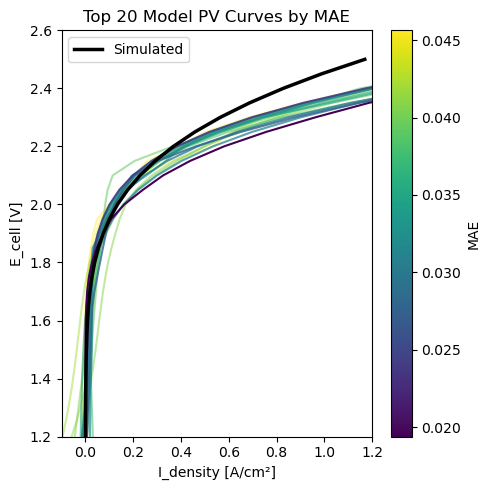

In [67]:
df_log = pd.read_csv(LOG_FILE)

# Sort by MAE and take top N models
top_df = df_log.sort_values(by='mae').head(topX).reset_index(drop=True)
mae_vals = top_df['mae'].values

# Normalize MAE values for color mapping
norm = mcolors.Normalize(vmin=mae_vals.min(), vmax=mae_vals.max())
cmap = cm.get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


plt.figure(figsize=(5, 5))
plt.ylim(1.2, 2.6)
plt.xlim(-0.1, 1.2)

# Plot top N models with color and alpha encoding by MAE
for i, model_row in reversed(list(top_df.iterrows())):
    model_path = os.path.join(MODELS_FOLDER, model_row.model_name + ".keras")
    scaler_path = os.path.join(MODELS_FOLDER, model_row.model_name + "_scaler.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        continue

    model = load_model(model_path, custom_objects={"LeakyReLU": LeakyReLU})
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X_full)
    I_pred = model.predict(X_scaled, verbose=False).flatten()

    color = cmap(norm(mae_vals[i]))
    alpha = 0.4 + 0.6 * (1 - norm(mae_vals[i]))  # alpha ∈ [0.4, 1.0]
    plt.plot(I_pred, E_sim.flatten(), color=color, alpha=alpha)

# Simulated curve
plt.plot(I_sim, E_sim.flatten(), color='black', linewidth=2.5, label='Simulated')

# Add colorbar for MAE
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label("MAE")


plt.title(f"Top {topX} Model PV Curves by MAE")
plt.xlabel("I_density [A/cm²]")
plt.ylabel("E_cell [V]")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, f"topX_models_pv_curves.png"))
plt.show()


Best Models by Metric vs Simulated

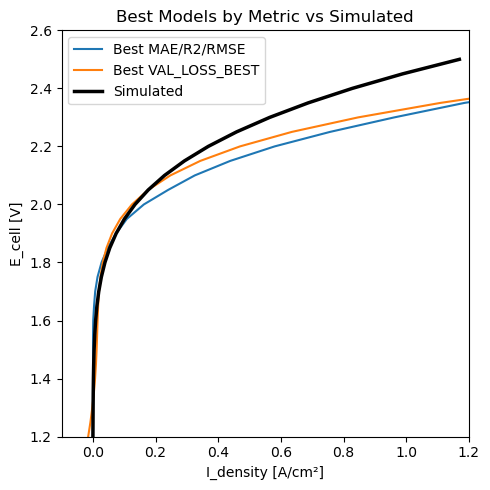

In [68]:
metrics = ['mae', 'r2', 'rmse', 'val_loss_best']
colors = sns.color_palette("tab10", len(metrics))

plt.figure(figsize=(5, 5))
plt.ylim(1.2, 2.6)
plt.xlim(-0.1, 1.2)

seen_models = {}
color_idx = 0

for metric in metrics:
    ascending = metric != 'r2'
    best = df_log.sort_values(by=metric, ascending=ascending).iloc[0]
    model_name = best.model_name

    if model_name in seen_models:
        seen_models[model_name]['labels'].append(metric.upper())
        continue

    model_path = os.path.join(MODELS_FOLDER, model_name + ".keras")
    scaler_path = os.path.join(MODELS_FOLDER, model_name + "_scaler.pkl")
    model = load_model(model_path, custom_objects={"LeakyReLU": LeakyReLU})
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X_full)
    I_pred = model.predict(X_scaled, verbose=False).flatten()

    seen_models[model_name] = {
        'I_pred': I_pred,
        'labels': [metric.upper()],
        'color': colors[color_idx % len(colors)]
    }
    color_idx += 1

# Plot unique models
for model_name, data in seen_models.items():
    label_str = f"Best {'/'.join(data['labels'])}"
    plt.plot(data['I_pred'], E_sim.flatten(), label=label_str, color=data['color'])

plt.plot(I_sim, E_sim.flatten(), color='black', linewidth=2.5, label='Simulated')
plt.title("Best Models by Metric vs Simulated")
plt.xlabel("I_density [A/cm²]")
plt.ylabel("E_cell [V]")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, "best_models_by_metric.png"))
plt.show()


Bar Plot of Metrics

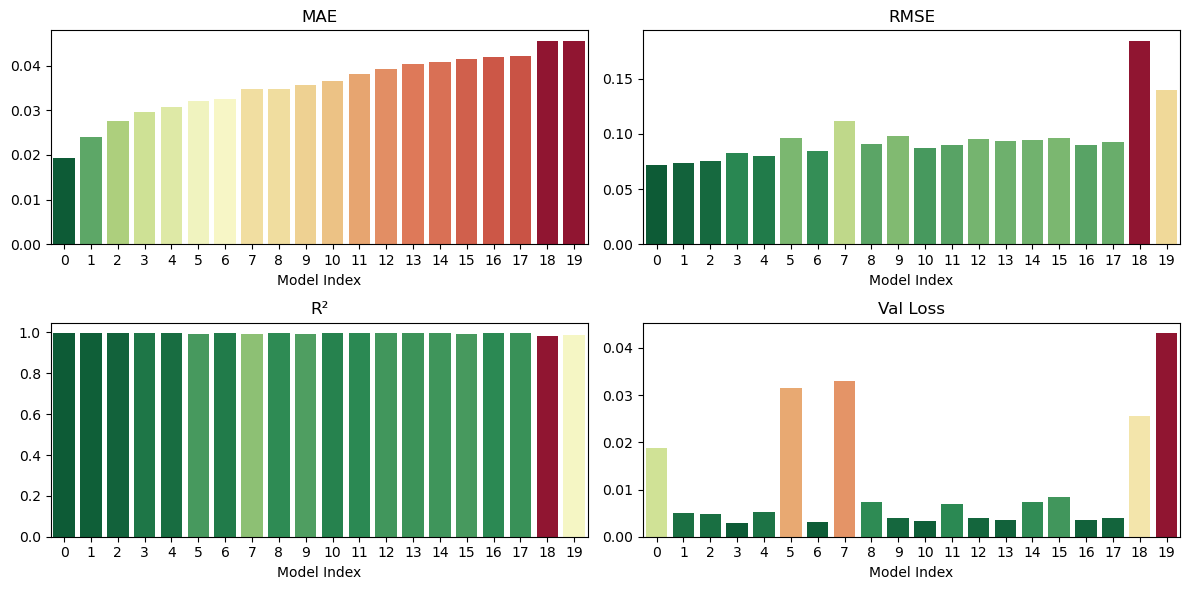

In [69]:
from matplotlib import colormaps
from matplotlib.colors import Normalize

plot_df = df_log[['model_name', 'mae', 'r2', 'rmse', 'val_loss_best']].copy()
plot_df = plot_df.sort_values(by='mae').head(topX).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
metrics = ['mae', 'rmse', 'r2', 'val_loss_best']
titles = ['MAE', 'RMSE', 'R²', 'Val Loss']
cmap_good_bad = colormaps["RdYlGn"]

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    values = plot_df[metric].values

    reverse = metric != 'r2'
    norm = Normalize(vmin=values.min(), vmax=values.max())
    if reverse:
        colors = [cmap_good_bad(1 - norm(v)) for v in values]
    else:
        colors = [cmap_good_bad(norm(v)) for v in values]

    sns.barplot(x=plot_df.index, y=values, hue=plot_df.index, palette=colors, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('Model Index')
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, "metric_bars_topX_models.png"))
plt.show()
